# Analyzing POIs more in-depth

The POI's are expected to lie consistently in certain subregions and exhibit a high degree of symmetry. In this notebook we'll analyze these geometric properties, which can be useful for data augmentation, spotting errors in the ground truth and defining constraints/loss functions that enforce consistent predictions.

In [7]:
import sys
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pqdm.threads import pqdm
from IPython.display import Image

sys.path.append('/home/daniel/Documents/Uni/MT/poi-prediction')

from src.dataset.dataset import ImplantsDataset, GruberDataset, PoiDataset
from src.transforms.transforms import LandmarksRandAffine

In [8]:
conversion_subreg = {
    'Arcus_Vertebrae': 41,
    'Spinosus_Process': 42,
    'Costal_Process_Left': 43,
    'Costal_Process_Right': 44,
    'Superior_Articular_Left': 45,
    'Superior_Articular_Right': 46,
    'Inferior_Articular_Left': 47,
    'Inferior_Articular_Right': 48,
    'Vertebra_Corpus_border': 49,
    'Vertebra_Corpus': 50,
}

subreg_id2txt = {v: k for k, v in conversion_subreg.items()}
subregs = [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

"""
Abbreviations:
- SSL: Supraspinous Ligament
- ALL: Anterior Longitudinal Ligament
- PLL: Posterior Longitudinal Ligament
- FL: Flavum Ligament
- ISL: Interspinous Ligament
- ITL: Intertransverse Ligament

- CR: Cranial / Superior
- CA: Caudal / Inferior

- S: Sinistra / Left
- D: Dextra / Right    
"""

conversion_poi = {
    "SSL": 81, 
    "ALL_CR_S": 109,
    "ALL_CR": 101,
    "ALL_CR_D": 117,
    "ALL_CA_S": 111,
    "ALL_CA": 103,
    "ALL_CA_D": 119,
    "PLL_CR_S": 110,
    "PLL_CR": 102,
    "PLL_CR_D": 118,
    "PLL_CA_S": 112,
    "PLL_CA": 104,
    "PLL_CA_D": 120,
    "FL_CR_S": 149,
    "FL_CR": 125,
    "FL_CR_D": 141,
    "FL_CA_S": 151,
    "FL_CA": 127,
    "FL_CA_D": 143,
    "ISL_CR": 134,
    "ISL_CA": 136,
    "ITL_S": 142,
    "ITL_D": 144,
}
conversion_poi2text = {k: f'{k}, {v}' for v, k in conversion_poi.items()}
poi_keys = [81, 101, 102, 103, 104, 109, 110, 111, 112, 117, 118, 119, 120, 125, 127, 134, 136, 141, 142, 143, 144, 149, 151]

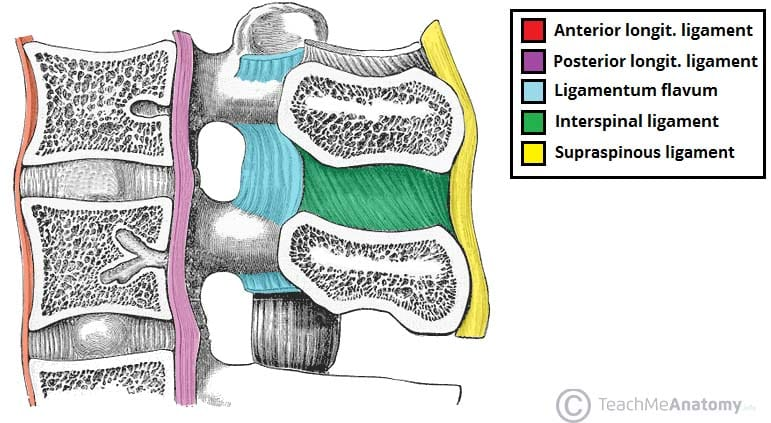

In [9]:
Image('Ligaments-of-the-Spine.jpg')

In [10]:
input_shape = (128, 128, 96)

gruber_master_df = pd.read_csv('/home/daniel/Data/Gruber/cutouts_scale-1-1-1/master_df.csv')

#Drop vertebrae 1-2 from gruber dataset
gruber_master_df = gruber_master_df[gruber_master_df['vertebra'] > 2]

#Drop vertebrae >= 25 from gruber dataset
gruber_master_df = gruber_master_df[gruber_master_df['vertebra'] <= 25]

#Drop subjects WS-09, WS-05, WS-17, WS-07, WS-08, WS-52
#gruber_master_df = gruber_master_df[~gruber_master_df['subject'].isin(['WS-09', 'WS-05', 'WS-17', 'WS-07', 'WS-08', 'WS-52'])]

all_subjects_gruber = gruber_master_df['subject'].unique()

theta = 0
transform = LandmarksRandAffine(
    prob = 0,
    rotate_range = ([-theta, theta], [-theta, theta], [-theta, theta]),
    shear_range = ([-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]),
    translate_range = ([-5, 5], [-5, 5], [-5, 5]),
    scale_range = ([-0.3, 0.1], [-0.3, 0.1], [-0.3, 0.1]),
    device = 'cpu'
)

gds = GruberDataset(
    master_df = gruber_master_df,
    input_shape = input_shape,
    transforms = None,
    flip_prob = 0,
)

In [11]:
#For each POI find the distance to the nearest neighbor in the surface and the corresponding subregion label
def get_dist_and_subreg(dd):

    p_idx_list = dd['target_indices']
    p_coord_list = dd['target']
    subreg_mask = dd['input'].squeeze()
    surface = dd['surface'].squeeze()

    non_zero_indices = torch.nonzero(surface, as_tuple=True)
    non_zero_labels = subreg_mask[non_zero_indices]
    non_zero_coords = torch.stack(non_zero_indices, dim=1).float()

    nearest_distances = torch.full((len(p_idx_list),), float('inf'))
    nearest_subregs = torch.full((len(p_idx_list),), -1, dtype=torch.long)

    data = []

    for i, (p_idx, p_coord) in enumerate(zip(p_idx_list, p_coord_list)):
        dists = torch.norm(non_zero_coords - p_coord, dim=1)
        min_idx = torch.argmin(dists)
        nearest_distances[i] = dists[min_idx]
        nearest_subregs[i] = non_zero_labels[min_idx]

        data.append({
            'subject': dd['subject'],
            'vertebra': dd['vertebra'],
            'poi': p_idx.item(),
            'nearest_dist': dists[min_idx].item(),
            'nearest_subreg': non_zero_labels[min_idx].int().item(),
        })

    return data

def get_spatial_consistency(dd):
    left_to_right_orders = {
        'all_cr_order': [109, 101, 117],
        'all_ca_order': [111, 103, 119],
        'pll_cr_order': [110, 102, 118],
        'pll_ca_order': [112, 104, 120],
        'fl_cr_order': [149, 125, 141],
        'fl_ca_order': [151, 127, 143],
        'itl_order': [142, 144]
    }

    top_to_bottom_orders = {
        'all_left_order': [109, 111],
        'all_center_order': [101, 103],
        'all_right_order': [117, 119],
        'pll_left_order': [110, 112],
        'pll_center_order': [102, 104],
        'pll_right_order': [118, 120],
        'fl_left_order': [149, 151],
        'fl_center_order': [125, 127],
        'fl_right_order': [141, 143],
        'isl_ssl_order': [134,81,136]
    }

    p_idx_list = dd['target_indices']
    p_coord_list = dd['target']

    p_idx_to_list_idx = {p_idx.item(): i for i, p_idx in enumerate(p_idx_list)}

    data = []

    for order_name, order_list in left_to_right_orders.items():
        order_indices = [p_idx_to_list_idx[p_idx] for p_idx in order_list]
        #LAS Format, hence 0 is the index of the left dir
        order_coords = [p_coord_list[i][0] for i in order_indices]
        if order_coords[0] > order_coords[1] and (len(order_coords) == 2 or order_coords[1] > order_coords[2]):
            data.append({
                'subject': dd['subject'],
                'vertebra': dd['vertebra'],
                'order_name': order_name,
                'consistent': True
            })
        else:
            data.append({
                'subject': dd['subject'],
                'vertebra': dd['vertebra'],
                'order_name': order_name,
                'consistent': False
            })

    for order_name, order_list in top_to_bottom_orders.items():
        order_indices = [p_idx_to_list_idx[p_idx] for p_idx in order_list]
        #LAS Format, hence 2
        order_coords = [p_coord_list[i][2] for i in order_indices]
        if order_coords[0] > order_coords[1]:
            data.append({
                'subject': dd['subject'],
                'vertebra': dd['vertebra'],
                'order_name': order_name,
                'consistent': True
            })
        else:
            data.append({
                'subject': dd['subject'],
                'vertebra': dd['vertebra'],
                'order_name': order_name,
                'consistent': False
            })

    return data

In [12]:
all_spatial_consitencies = pqdm(gds, get_spatial_consistency, n_jobs=8, desc='Spatial Consistency')

all_spatial_consitencies_df = pd.DataFrame([item for sublist in all_spatial_consitencies for item in sublist])

QUEUEING TASKS | Spatial Consistency:   0%|          | 0/788 [00:00<?, ?it/s]

PROCESSING TASKS | Spatial Consistency:   0%|          | 0/788 [00:00<?, ?it/s]

COLLECTING RESULTS | Spatial Consistency:   0%|          | 0/788 [00:00<?, ?it/s]

In [13]:
all_closest_subregs = pqdm(gds, get_dist_and_subreg, n_jobs = 8)

#Flatten the list of lists
all_closest_subregs = [item for sublist in all_closest_subregs for item in sublist]

df = pd.DataFrame(all_closest_subregs)


QUEUEING TASKS | :   0%|          | 0/788 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/788 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/788 [00:00<?, ?it/s]

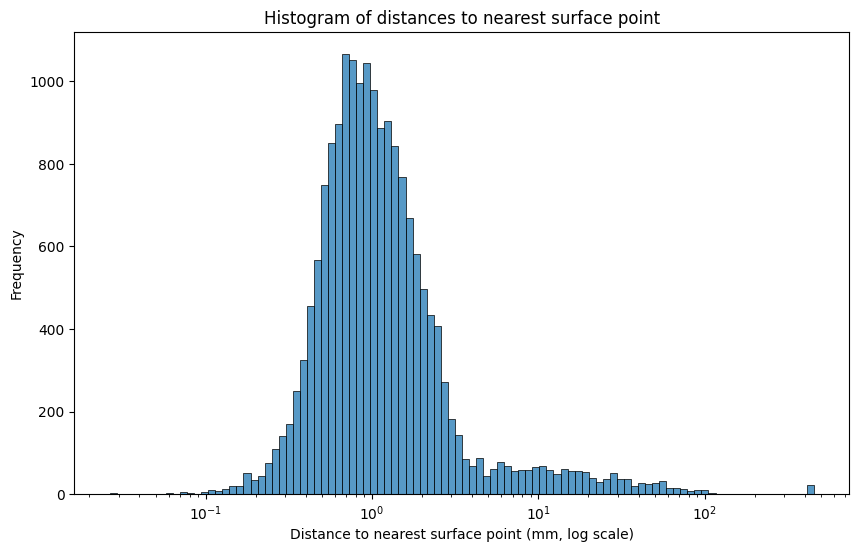

In [14]:
#Create a histogram of the distances with a log scale for the x-axis
plt.figure(figsize=(10, 6))
sns.histplot(df['nearest_dist'], bins=100, log_scale=(True, False))
plt.xlabel('Distance to nearest surface point (mm, log scale)')
plt.ylabel('Frequency')
plt.title('Histogram of distances to nearest surface point')
plt.show()

In [15]:
#Calculate mean, median, std, min, max, 25th and 75th percentile
df['nearest_dist'].describe()

count    18124.000000
mean         3.136774
std         17.674590
min          0.026479
25%          0.643354
50%          0.986225
75%          1.645285
max        454.941437
Name: nearest_dist, dtype: float64

In [16]:
#Print the mean and median, std, min, max, 25th and 75th percentile of the distances grouped by subject
df.groupby('subject')['nearest_dist'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
WS-09,506.0,23.836039,20.256939,0.107746,4.515271,19.745077,40.786570,73.076866
WS-23,506.0,21.801192,94.614903,0.110462,0.659827,1.040676,1.719783,454.941437
WS-05,506.0,11.346667,11.071581,0.128064,1.552662,7.641626,19.051941,42.797089
WS-18,506.0,8.882434,24.868463,0.062946,0.657109,1.069690,1.790928,115.667152
WS-17,506.0,7.497997,6.611709,0.236859,2.076069,5.668475,11.216388,30.460815
WS-07,506.0,4.409385,4.369046,0.138076,0.892415,2.238512,6.898271,17.088488
WS-08,506.0,3.181412,3.048528,0.173171,0.894478,1.997593,4.334668,14.023142
WS-15,506.0,1.952535,1.161999,0.177497,0.974757,1.749854,2.719606,5.759205
WS-00,506.0,1.418375,0.789110,0.110817,0.739183,1.280101,1.985717,3.525847


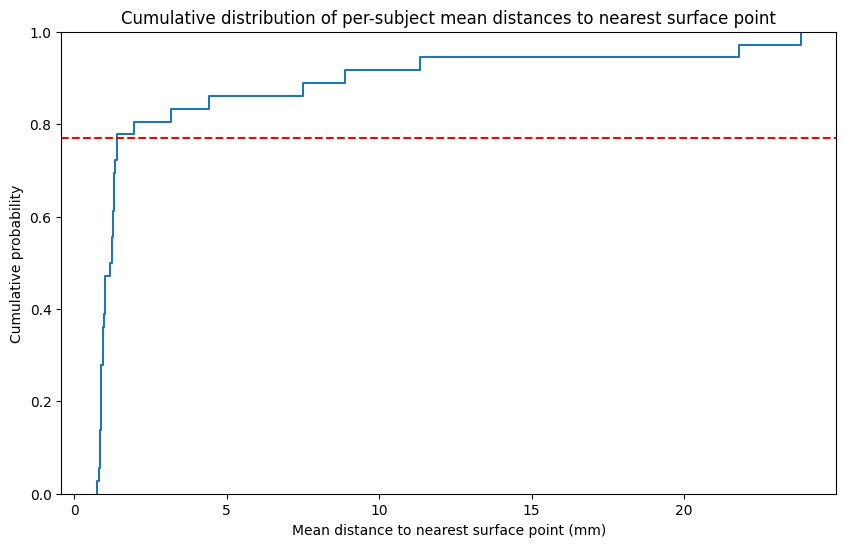

In [17]:
#Plot the cumulative distribution of the per-subject mean distances
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df.groupby('subject')['nearest_dist'].mean())
plt.xlabel('Mean distance to nearest surface point (mm)')
plt.ylabel('Cumulative probability')
plt.title('Cumulative distribution of per-subject mean distances to nearest surface point')
#Draw a horizontal line at 80% to show the 80% quantile
plt.axhline(0.77, color='r', linestyle='--')
plt.show()

In [18]:
#Print the mean and median, std, min, max, 25th and 75th percentile of the distances grouped by poi
df.groupby('poi')['nearest_dist'].describe().sort_values('mean', ascending=False).rename(conversion_poi2text)

,count,mean,std,min,25%,50%,75%,max
poi,,,,,,,,
"103, ALL_CA",788.0,4.730174,18.811931,0.103001,0.774875,1.380600,2.322279,454.941437
"111, ALL_CA_S",788.0,4.700533,18.714211,0.059033,0.793901,1.293342,2.253982,454.941437
"119, ALL_CA_D",788.0,4.502077,18.728190,0.036711,0.714564,1.313476,2.194777,454.941437
"112, PLL_CA_S",788.0,4.204194,17.840204,0.120179,1.037472,1.624381,2.636850,454.941437
"104, PLL_CA",788.0,4.080826,17.889856,0.172062,0.948849,1.546187,2.425467,454.941437
"120, PLL_CA_D",788.0,4.003655,17.866129,0.175734,0.936779,1.539748,2.488776,454.941437
"142, ITL_S",788.0,3.127714,17.742261,0.044644,0.547598,0.802494,1.235830,454.941437
"151, FL_CA_S",788.0,3.090938,17.496746,0.062946,0.742892,1.155036,1.787556,454.941437
"143, FL_CA_D",788.0,3.079211,17.547727,0.148409,0.764996,1.175848,1.872797,454.941437


In [19]:
#Print the mean and median, std, min, max, 25th and 75th percentile of the distances grouped by poi
df.groupby('vertebra')['nearest_dist'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
vertebra,,,,,,,,
17,828.0,14.076570,74.597721,0.138744,0.661941,0.983395,1.552029,454.941437
3,805.0,4.412485,11.329829,0.110462,0.621376,0.946344,1.631548,73.076866
4,805.0,4.138430,10.653518,0.059033,0.573979,0.865316,1.600528,68.574432
5,805.0,3.982421,10.109138,0.026479,0.617095,0.918722,1.572756,68.304146
6,805.0,3.901729,9.456043,0.084535,0.686872,1.073580,1.770601,62.868343
20,828.0,3.897507,14.676171,0.044644,0.619882,0.947157,1.528673,115.667152
23,828.0,3.890995,14.071090,0.076367,0.606798,0.902112,1.588834,104.524994
7,828.0,3.634534,8.266123,0.096321,0.744144,1.247645,2.147420,59.168140
8,828.0,3.398937,7.386448,0.103388,0.846888,1.366450,2.289806,56.589710


In [20]:
#Let's see for each POI how often each subreg occurs
df.groupby(['poi', 'nearest_subreg']).size().unstack().fillna(0).rename(columns = subreg_id2txt, index = conversion_poi2text)

nearest_subreg,Arcus_Vertebrae,Spinosus_Process,Costal_Process_Left,Costal_Process_Right,Superior_Articular_Left,Superior_Articular_Right,Inferior_Articular_Left,Inferior_Articular_Right,Vertebra_Corpus_border
poi,,,,,,,,,
"81, SSL",0.0,778.0,0.0,0.0,5.0,1.0,3.0,0.0,1.0
"101, ALL_CR",0.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,781.0
"102, PLL_CR",0.0,0.0,0.0,1.0,1.0,5.0,5.0,1.0,775.0
"103, ALL_CA",0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,783.0
"104, PLL_CA",0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.0,774.0
"109, ALL_CR_S",0.0,0.0,2.0,0.0,1.0,0.0,1.0,5.0,779.0
"110, PLL_CR_S",233.0,0.0,0.0,0.0,2.0,0.0,12.0,0.0,541.0
"111, ALL_CA_S",0.0,0.0,0.0,0.0,1.0,0.0,2.0,5.0,780.0
"112, PLL_CA_S",0.0,1.0,1.0,0.0,1.0,0.0,18.0,0.0,767.0


Comments:

SSL/ISL (Supraspinous/Intraspinous Ligament): Connect the Processi Spinosi and is therefore expected to always lie on this subregion. Any other cases are necessarily wrong and require inspection.

ALL (Anterior Longit. Ligament): Wraps around the front part of the corpus and touches nothing but the corpus.

PLL (Posterior Longit. Ligament): The center points (PLL_CR / PLL_CA) should again only touch the corpus border. The left/right points are in the bend where the corpus and the pediculus/arcus vertebrae touch, but should still be on the corpus conceptually.

FL (Flavum Ligament): The center points both superior and inferior (FL_CR, FL_CA) should sit firmly on the arcus vertebrae subregion. The superior left and right (FL_CR_S, FL_CR_D) can touch the superior articular left and right respectively and the same goes for the inferior (FL_CA_S, FL_CR_D) with the inferior articular left and right.

ITL (Intertransverse Ligament): The left/right (FL_S, FL_D) attachment points are always on the left/right costal process respectively.

In [21]:
acceptable_subregs = {
    81: [42],
    101: [49],
    102: [49],
    103: [49],
    104: [49],
    109: [49],
    110: [41, 49],
    111: [49],
    112: [49],
    117: [49],
    118: [41, 49],
    119: [49],
    120: [49],
    125: [41],
    127: [41],
    134: [42],
    136: [42],
    141: [41, 46],
    142: [43],
    143: [41, 48],
    144: [44],
    149: [41,45],
    151: [41,47]
}

#Pretty print the acceptable subregions with each POI in text form
acceptable_subregs_text = {conversion_poi2text[k]: [subreg_id2txt[subreg] for subreg in v] for k, v in acceptable_subregs.items()}
acceptable_subregs_text

{'81, SSL': ['Spinosus_Process'],
 '101, ALL_CR': ['Vertebra_Corpus_border'],
 '102, PLL_CR': ['Vertebra_Corpus_border'],
 '103, ALL_CA': ['Vertebra_Corpus_border'],
 '104, PLL_CA': ['Vertebra_Corpus_border'],
 '109, ALL_CR_S': ['Vertebra_Corpus_border'],
 '110, PLL_CR_S': ['Arcus_Vertebrae', 'Vertebra_Corpus_border'],
 '111, ALL_CA_S': ['Vertebra_Corpus_border'],
 '112, PLL_CA_S': ['Vertebra_Corpus_border'],
 '117, ALL_CR_D': ['Vertebra_Corpus_border'],
 '118, PLL_CR_D': ['Arcus_Vertebrae', 'Vertebra_Corpus_border'],
 '119, ALL_CA_D': ['Vertebra_Corpus_border'],
 '120, PLL_CA_D': ['Vertebra_Corpus_border'],
 '125, FL_CR': ['Arcus_Vertebrae'],
 '127, FL_CA': ['Arcus_Vertebrae'],
 '134, ISL_CR': ['Spinosus_Process'],
 '136, ISL_CA': ['Spinosus_Process'],
 '141, FL_CR_D': ['Arcus_Vertebrae', 'Superior_Articular_Right'],
 '142, ITL_S': ['Costal_Process_Left'],
 '143, FL_CA_D': ['Arcus_Vertebrae', 'Inferior_Articular_Right'],
 '144, ITL_D': ['Costal_Process_Right'],
 '149, FL_CR_S': ['Arcu

In [22]:
#Let's see for each POI how often it is outside of the acceptable subreg
df['acceptable_subreg'] = df.apply(lambda x: x['nearest_subreg'] in acceptable_subregs[x['poi']], axis = 1)

In [23]:
df.groupby(['poi', 'acceptable_subreg']).size().unstack().fillna(0).rename(columns = {True: 'acceptable', False: 'unacceptable'}, index = conversion_poi2text)

acceptable_subreg,unacceptable,acceptable
poi,,
"81, SSL",10,778
"101, ALL_CR",7,781
"102, PLL_CR",13,775
"103, ALL_CA",5,783
"104, PLL_CA",14,774
"109, ALL_CR_S",9,779
"110, PLL_CR_S",14,774
"111, ALL_CA_S",8,780
"112, PLL_CA_S",21,767


In [24]:
#Determine the percentage of POIs that are outside of the acceptable subreg
df['acceptable_subreg'].mean()

0.9640256014124917

In [25]:
#Calculate the percentage of acceptable subregs
df.groupby(['poi', 'acceptable_subreg']).size().unstack().fillna(0).apply(lambda x: round((x[0] * 100 / (x[0] + x[1])), 2), axis = 1).rename(index = conversion_poi2text)

poi
81, SSL           1.27
101, ALL_CR       0.89
102, PLL_CR       1.65
103, ALL_CA       0.63
104, PLL_CA       1.78
109, ALL_CR_S     1.14
110, PLL_CR_S     1.78
111, ALL_CA_S     1.02
112, PLL_CA_S     2.66
117, ALL_CR_D     0.76
118, PLL_CR_D     1.27
119, ALL_CA_D     0.76
120, PLL_CA_D     1.65
125, FL_CR        7.74
127, FL_CA       19.16
134, ISL_CR       1.40
136, ISL_CA       1.27
141, FL_CR_D      4.44
142, ITL_S        6.09
143, FL_CA_D      6.73
144, ITL_D        5.46
149, FL_CR_S      6.22
151, FL_CA_S      6.98
dtype: float64

In [45]:
# Mark the subjects that failed visual inspection
failed_subjects = ['WS-09', 'WS-05', 'WS-17', 'WS-07', 'WS-08']

df_no_failed = df[~df['subject'].isin(failed_subjects)]

In [29]:
#Evaluate wether the spatial consistency holds for all tested orders
all_spatial_consitencies_df.groupby(['subject', 'vertebra']).all().mean()

#Create a table indicating for all subject-vertebra pairs wether all spatial consistency checks hold
consistent_sub_vert_pairs = all_spatial_consitencies_df.groupby(['subject', 'vertebra']).all()

In [30]:
consistent_sub_vert_pairs[consistent_sub_vert_pairs['consistent']]

order_name  consistent
subject vertebra                        
WS-00   3               True        True
        4               True        True
        5               True        True
        6               True        True
        7               True        True
...                      ...         ...
WS-63   20              True        True
        21              True        True
        22              True        True
        23              True        True
        24              True        True

[758 rows x 2 columns]

In [32]:
inconsistent_sub_vert_pairs = consistent_sub_vert_pairs[~consistent_sub_vert_pairs['consistent']]
inconsistent_sub_vert_pairs.count()

order_name    30
consistent    30
dtype: int64

In [37]:
#Get all subject-vertebra combinations where the mean distance to the surface is above 2mm
bad_dist_vertebrae = df.groupby(['subject', 'vertebra'])['nearest_dist'].mean().reset_index()
bad_dist_vertebrae = bad_dist_vertebrae[bad_dist_vertebrae['nearest_dist'] > 2]
bad_dist_vertebrae.head()

,subject,vertebra,nearest_dist
22,WS-05,3,31.339641
23,WS-05,4,29.325500
24,WS-05,5,27.407414
25,WS-05,6,24.469997
26,WS-05,7,20.901643


In [58]:
#Get number of subject-vertebra pairs that have bad distance, are inconsistent, both or neither
all_sub_vert_pairs = df[['subject', 'vertebra']].drop_duplicates()

#Drop the subjects that failed visual inspection
all_sub_vert_pairs = all_sub_vert_pairs[~all_sub_vert_pairs['subject'].isin(failed_subjects)]

all_sub_vert_pairs['bad_dist'] = all_sub_vert_pairs.apply(lambda x: (x['subject'], x['vertebra']) in bad_dist_vertebrae[['subject', 'vertebra']].values, axis=1)
all_sub_vert_pairs['inconsistent'] = all_sub_vert_pairs.apply(lambda x: (x['subject'], x['vertebra']) in inconsistent_sub_vert_pairs.index, axis=1)

#Get the number of subject-vertebra pairs that are both inconsistent and have a bad distance
both = all_sub_vert_pairs[(all_sub_vert_pairs['bad_dist'] == True) & (all_sub_vert_pairs['inconsistent'] == True)].count()

#Get the number of subject-vertebra pairs that are inconsistent but have a good distance
inconsistent_only = all_sub_vert_pairs[(all_sub_vert_pairs['bad_dist'] == False) & (all_sub_vert_pairs['inconsistent'] == True)].count()

#Get the number of subject-vertebra pairs that are consistent but have a bad distance
bad_dist_only = all_sub_vert_pairs[(all_sub_vert_pairs['bad_dist'] == True) & (all_sub_vert_pairs['inconsistent'] == False)].count()

#Get the number of subject-vertebra pairs that are consistent and have a good distance
good = all_sub_vert_pairs[(all_sub_vert_pairs['bad_dist'] == False) & (all_sub_vert_pairs['inconsistent'] == False)].count()

both, inconsistent_only, bad_dist_only, good

(subject         4
 vertebra        4
 bad_dist        4
 inconsistent    4
 dtype: int64,
 subject         25
 vertebra        25
 bad_dist        25
 inconsistent    25
 dtype: int64,
 subject         102
 vertebra        102
 bad_dist        102
 inconsistent    102
 dtype: int64,
 subject         547
 vertebra        547
 bad_dist        547
 inconsistent    547
 dtype: int64)

In [63]:
#All pairs that are in either or both categories belong to the failed subject-vertebra pairs
failed_subject_vertebra_pairs = all_sub_vert_pairs[(all_sub_vert_pairs['bad_dist'] == True) | (all_sub_vert_pairs['inconsistent'] == True)]

#Index by subject and vertebra
failed_subject_vertebra_pairs.set_index(['subject', 'vertebra'], inplace=True)

failed_subject_vertebra_pairs.head(), failed_subject_vertebra_pairs.count()

(                  bad_dist  inconsistent
 subject vertebra                        
 WS-06   7            False          True
         20           False          True
         22           False          True
         23           False          True
         24           False          True,
 bad_dist        131
 inconsistent    131
 dtype: int64)

In [73]:
#Get all subject-vertebra-poi combinations where the distance to the surface is above 3mm
bad_pois_by_dist = df[df['nearest_dist'] > 3]

#Drop failed subjects
bad_pois_by_dist = bad_pois_by_dist[~bad_pois_by_dist['subject'].isin(failed_subjects)]

#Index by subject and vertebra
bad_pois_by_dist.set_index(['subject', 'vertebra'], inplace=True)

#Drop failed subject-vertebra pairs
bad_pois_by_dist = bad_pois_by_dist[~bad_pois_by_dist.index.isin(failed_subject_vertebra_pairs.index)]

#count how many bad_pois_by dist also have an unacceptable subreg
bad_pois_by_dist.count(), bad_pois_by_dist['acceptable_subreg'].count(), len(bad_pois_by_dist) - bad_pois_by_dist['acceptable_subreg'].sum()

(poi                  150
 nearest_dist         150
 nearest_subreg       150
 acceptable_subreg    150
 dtype: int64,
 150,
 6)

In [83]:
#Get number of all pois minus those with bad distance
all_pois = df_no_failed.copy()

#Index by subject and vertebra
all_pois.set_index(['subject', 'vertebra'], inplace=True)

#Drop failed subject-vertebra pairs
all_pois = all_pois[~all_pois.index.isin(failed_subject_vertebra_pairs.index)]

#Count how many pois are in the dataset
print(len(all_pois))

#Count how many pois are in the dataset and have an acceptable subreg and a good distance
print(all_pois['acceptable_subreg'][all_pois['nearest_dist'] <= 3].sum())

#Count how many pois are in the dataset and have an acceptable subreg, but a bad distance
print(all_pois['acceptable_subreg'][all_pois['nearest_dist'] > 3].sum())

#Count how many pois are in the dataset and have an unacceptable subreg but a good distance
print((~all_pois['acceptable_subreg'])[all_pois['nearest_dist'] <= 3].sum())

#Count how many pois are in the dataset and have an unacceptable subreg overall
print((~all_pois['acceptable_subreg']).sum(), all_pois['acceptable_subreg'].sum())

#Count how many pois overall have a good distance
print((all_pois['nearest_dist'] <= 3).sum())


12581
12295
144
136
142 12439
12431


In [75]:
#Get all subject-vertebra-poi combinations where the subreg is not acceptable
bad_pois_by_subreg = df[~df['acceptable_subreg']]
#Drop failed subjects
bad_pois_by_subreg = bad_pois_by_subreg[~bad_pois_by_subreg['subject'].isin(failed_subjects)]

#Index by subject and vertebra
bad_pois_by_subreg.set_index(['subject', 'vertebra'], inplace=True)

#Drop failed subject-vertebra pairs
bad_pois_by_subreg = bad_pois_by_subreg[~bad_pois_by_subreg.index.isin(failed_subject_vertebra_pairs.index)]

bad_pois_by_subreg.head(), bad_pois_by_subreg.count()

(                  poi  nearest_dist  nearest_subreg  acceptable_subreg
 subject vertebra                                                      
 WS-06   17        127      1.102426              42              False
         18        127      0.903814              42              False
         19        127      0.932428              48              False
 WS-48   3          81      1.484677              47              False
         3         136      0.469154              47              False,
 poi                  142
 nearest_dist         142
 nearest_subreg       142
 acceptable_subreg    142
 dtype: int64)

In [54]:
('WS-06', 7, 104) in bad_pois_by_dist[['subject', 'vertebra', 'poi']].values

True

In [46]:
#Get all subject-vertebra-poi combinations where the distance is too large, the subreg is unacceptable, both, or neither
all_pois = df[['subject', 'vertebra', 'poi']].drop_duplicates()

#Drop failed subjects and failed sub-vertebra pairs
all_pois = all_pois[~all_pois['subject'].isin(failed_subjects)]
all_pois = all_pois[~all_pois.apply(lambda x: (x['subject'], x['vertebra']) in inconsistent_sub_vert_pairs.values, axis=1)]

all_pois['bad_dist'] = all_pois.apply(lambda x: (x['subject'], x['vertebra'], x['poi']) in bad_pois_by_dist[['subject', 'vertebra', 'poi']].values, axis=1)
all_pois['bad_subreg'] = all_pois.apply(lambda x: (x['subject'], x['vertebra'], x['poi']) in bad_pois_by_subreg[['subject', 'vertebra', 'poi']].values, axis=1)

#Get the number of subject-vertebra-poi combinations that have both a bad distance and an unacceptable subreg
both = all_pois[(all_pois['bad_dist'] == True) & (all_pois['bad_subreg'] == True)].count()

#Get the number of subject-vertebra-poi combinations that have an unacceptable subreg but a good distance
bad_subreg_only = all_pois[(all_pois['bad_dist'] == False) & (all_pois['bad_subreg'] == True)].count()

#Get the number of subject-vertebra-poi combinations that have a bad distance but an acceptable subreg
bad_dist_only = all_pois[(all_pois['bad_dist'] == True) & (all_pois['bad_subreg'] == False)].count()

#Get the number of subject-vertebra-poi combinations that have a good distance and an acceptable subreg
good = all_pois[(all_pois['bad_dist'] == False) & (all_pois['bad_subreg'] == False)].count()

both, bad_subreg_only, bad_dist_only, good

(subject       13455
 vertebra      13455
 poi           13455
 bad_dist      13455
 bad_subreg    13455
 dtype: int64,
 subject       1472
 vertebra      1472
 poi           1472
 bad_dist      1472
 bad_subreg    1472
 dtype: int64,
 subject       0
 vertebra      0
 poi           0
 bad_dist      0
 bad_subreg    0
 dtype: int64,
 subject       0
 vertebra      0
 poi           0
 bad_dist      0
 bad_subreg    0
 dtype: int64)

In [94]:
#Drop all subjects that failed visual inspection and all subject-vertebra combinations where the mean distance to the surface is above 2mm
df = df[~df['subject'].isin(failed_subjects)]
df = df[~df.set_index(['subject', 'vertebra']).index.isin(bad_dist_vertebrae.set_index(['subject', 'vertebra']).index)]

#Mark all subject-vertebra-poi combinations where the distance to the surface is above 3mm or the subreg is not acceptable in a new column 'bad_gt'
df['bad_gt'] = df.apply(lambda x: x['nearest_dist'] > 3 or not x['acceptable_subreg'], axis = 1)

In [95]:
#Count the number of remaining POIs
df.count()

subject              16629
vertebra             16629
poi                  16629
nearest_dist         16629
nearest_subreg       16629
acceptable_subreg    16629
bad_gt               16629
dtype: int64

In [96]:
#Count the number of remaining POIs that are marked as bad
df['bad_gt'].sum()

876

In [99]:
#Get the min, max and mean number of good POIs per subject-vertebra combination
good_pois = df[~df['bad_gt']]
good_pois.groupby(['subject', 'vertebra'])['poi'].count().describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    723.000000
mean      21.788382
std        3.031831
min        1.000000
1%         9.000000
5%        18.000000
25%       22.000000
50%       23.000000
75%       23.000000
95%       23.000000
99%       23.000000
max       23.000000
Name: poi, dtype: float64

In [100]:
#Print the mean and median, std, min, max, 25th and 75th percentile of the distances grouped by subject
good_pois.groupby('subject')['nearest_dist'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
WS-15,295.0,1.403162,0.715708,0.249717,0.824141,1.248817,1.978481,2.989671
WS-00,511.0,1.342581,0.721200,0.110817,0.712428,1.212942,1.903965,2.998154
WS-13,514.0,1.322435,0.748632,0.106723,0.684986,1.198629,1.897617,2.993619
WS-54,524.0,1.275754,0.709130,0.026479,0.667588,1.132779,1.810994,2.989042
WS-55,532.0,1.254273,0.686528,0.072256,0.660659,1.107201,1.740623,2.931643
WS-30,531.0,1.253323,0.704135,0.128468,0.644435,1.108947,1.753627,2.956409
WS-47,512.0,1.245823,0.698854,0.072076,0.664651,1.077982,1.761298,2.962577
WS-62,514.0,1.243305,0.726454,0.108101,0.630663,1.094993,1.818754,2.995047
WS-36,511.0,1.213235,0.679120,0.109763,0.655150,1.041813,1.702923,2.983617


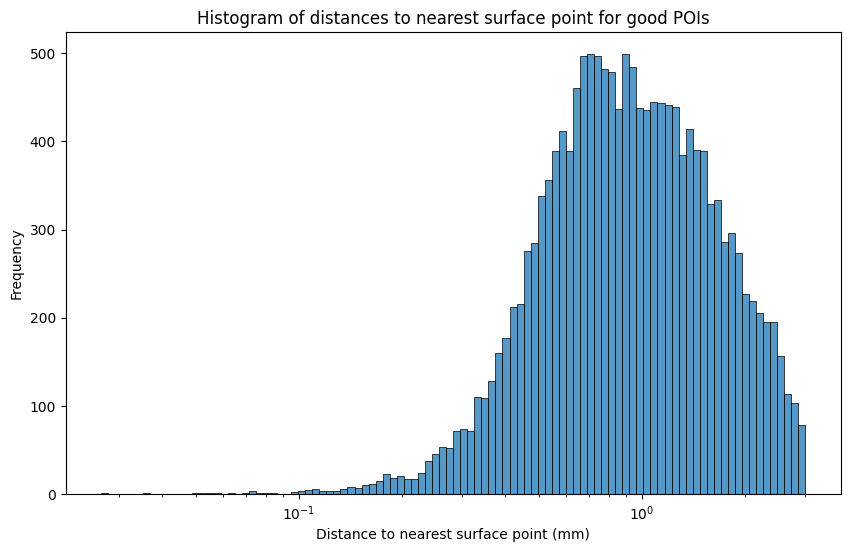

In [104]:
#Plot the surface distance distribution for good POIs
plt.figure(figsize=(10, 6))
sns.histplot(good_pois['nearest_dist'], bins=100, log_scale=(True, False))
plt.xlabel('Distance to nearest surface point (mm)')
plt.ylabel('Frequency')
plt.title('Histogram of distances to nearest surface point for good POIs')
plt.show()

In [115]:
master_df = pd.read_csv('/home/daniel/Data/Gruber/cutouts_scale-1-1-1/master_df.csv')

In [116]:
master_df.head()

,subject,vertebra,file_dir
0,WS-06,1,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...
1,WS-06,2,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...
2,WS-06,3,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...
3,WS-06,4,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...
4,WS-06,5,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...


In [121]:
#Add a column "use_sample" in master_df which is false if the subject is in "failed_subjects" or the subject-vertebra pair is in "bad_subjects" or the subject-vertebra pair is not consistent
master_df['use_sample'] = ~master_df['subject'].isin(failed_subjects)
master_df['use_sample'] = master_df['use_sample'] & ~master_df.set_index(['subject', 'vertebra']).index.isin(bad_dist_vertebrae.set_index(['subject', 'vertebra']).index)
master_df['use_sample'] = master_df['use_sample'] & master_df.set_index(['subject', 'vertebra']).index.isin(consistent_sub_vert_pairs[consistent_sub_vert_pairs['consistent']].index)

In [123]:
#Add a column "bad_poi_list" that contains for each subject-vertebrae pair all pois that are either in bad_pois_by_dist or bad_pois_by_subreg
master_df['bad_poi_list'] = master_df.set_index(['subject', 'vertebra']).index.map(lambda x: bad_pois_by_dist[bad_pois_by_dist.set_index(['subject', 'vertebra']).index == x]['poi'].tolist() + bad_pois_by_subreg[bad_pois_by_subreg.set_index(['subject', 'vertebra']).index == x]['poi'].tolist())

In [124]:
#Remove duplicates from all bad_poi_list entries
master_df['bad_poi_list'] = master_df['bad_poi_list'].map(lambda x: list(set(x)))

In [125]:
master_df.head()

,subject,vertebra,file_dir,use_sample,bad_poi_list
0,WS-06,1,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...,False,"[101, 102, 103, 104, 134, 136, 109, 111, 112, ..."
1,WS-06,2,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...,True,[]
2,WS-06,3,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...,True,[]
3,WS-06,4,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...,True,[]
4,WS-06,5,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...,True,[]


In [126]:
#Get min, mean and maximum length of bad_poi_list
master_df['n_bad_pois'] = master_df['bad_poi_list'].map(len)

In [127]:
#Get min, mean and maximum length of bad_poi_list by vertebra
master_df.groupby('vertebra')['n_bad_pois'].describe()

,count,mean,std,min,25%,50%,75%,max
vertebra,,,,,,,,
1,35.0,13.857143,4.180788,7.0,12.0,13.0,14.00,23.0
2,35.0,3.514286,7.232978,0.0,0.0,0.0,1.50,23.0
3,35.0,3.828571,7.663841,0.0,0.0,0.0,2.00,23.0
4,35.0,3.514286,7.488703,0.0,0.0,0.0,1.50,23.0
5,35.0,3.600000,7.365260,0.0,0.0,0.0,2.00,23.0
6,35.0,3.828571,7.461610,0.0,0.0,0.0,2.00,23.0
7,36.0,3.916667,6.913238,0.0,0.0,1.0,3.00,23.0
8,36.0,3.611111,6.582565,0.0,0.0,1.0,2.00,23.0
9,36.0,3.250000,6.433728,0.0,0.0,1.0,2.00,23.0


In [128]:
master_df.use_sample.mean()

0.8018648018648019

In [129]:
#Save master_df
master_df.to_csv('/home/daniel/Data/Gruber/cutouts_scale-1-1-1/master_df_cleaned.csv', index=False)

In [67]:
master_df_cleaned = pd.read_csv('/home/daniel/Data/Gruber/cutouts_scale-1-1-1/master_df_cleaned.csv')
import ast

In [69]:
master_df_cleaned['bad_poi_list'] = master_df_cleaned['bad_poi_list'].apply(ast.literal_eval)

In [72]:
row = master_df_cleaned.iloc[0]

In [73]:
row['bad_poi_list']

[101, 102, 103, 104, 134, 136, 109, 111, 112, 81, 117, 118, 119, 120]

In [63]:
master_df.iloc[0]['bad_poi_list']

[101, 102, 103, 104, 134, 136, 109, 111, 112, 81, 117, 118, 119, 120]